In [1]:
from sklearn.inspection import PartialDependenceDisplay
# ==== 1) load packages ====
import numpy as np
import pandas as pd
import math
import glob
from sklearn.metrics import ndcg_score
from sklearn.preprocessing import StandardScaler
import torch
import os
import random
os.chdir(
    # "/home/yliu420/Project/Belief-Elicitation-on-LLM-postrelease/analysis"
    "/Users/xiaobaodawang/Research/Belif-Elicitation-on-LLM-postrelease/analysis"
)
from analysis_pkg.preprocess import *
from analysis_pkg.models import *
from PCA_TSNE_scoremodel.visualization import *
from llm_belief.analysis import visualize_probability_distribution
from analysis_pkg.visualization_FA import *
# from analysis_pkg.partialdependentplot import *
from analysis_pkg.adptive_lasso import *
from analysis_pkg.pdp_plot import *
torch.manual_seed(2025)
random.seed(2025)

# Prepare data

In [2]:
# ==== 2) load training data ====
processes = 10
## load profiles and LLM expectations to profiles and df
fl = [f"../output/{i*1000}_{(i+1)*1000}.csv" for i in range(processes)]
# combine all csv files
df = pd.concat([pd.read_csv(f) for f in fl])
profiles = pd.read_csv("../data/profiles_shuffled.csv")

In [3]:
# ==== 3) preprocess training data ====
## split to Xi and Xj by odd and even rows
X = preprocess(profiles[:2000*processes])
Xi = X[0:2000*processes:2]
Xj = X[1:2000*processes:2]
y = df["profile_id"].apply(lambda x: 1 if x % 2 == 0 else -1)
y = torch.from_numpy(y.values).float()
P, d = Xi.shape

In [4]:
# ==== 4) train model, and calibration ====
split = int(0.9 * P)
ds_tr = PairwiseDataset(Xi[:split], Xj[:split], y[:split])
ds_va = PairwiseDataset(Xi[split:], Xj[split:], y[split:])
dl_tr = DataLoader(ds_tr, batch_size=64, shuffle=True, num_workers=0)
dl_va = DataLoader(ds_va, batch_size=64, shuffle=False, num_workers=0)

In [5]:
# ==== randomly sample 1000 profiles as validation set ====
test_indices = random.sample(range(profiles.shape[0]), 1000)
profiles_val = profiles.iloc[test_indices].reset_index(drop=True)
# set dtype of column 8 to float64
profiles_val['RAM'] = profiles_val['RAM'].astype('float64')
## preprocess all profiles
X_val = preprocess_test(profiles_val.iloc[:,:10])
features = profiles_val.columns.tolist()[:10]
X_val_df = pd.DataFrame(X_val, columns=features)

In [6]:
real_profiles = pd.read_csv("../data/real_profiles.csv")
real_profiles.set_index('real model', inplace=True)

# AdaLasso + Interaction + Square

In [7]:
torch.manual_seed(2025)
model = LinearInteractionModel(
    in_dim=d,
    include_interaction=True,   # 是否加入交互项
    poly_degree=2,       # 多项式的最高次数
)

# 2) 训练：两阶段 Adaptive Lasso + 自动选 λ（不改你原来的训练/打分代码）
model, info = train_pairwise_adalasso(
    model,
    train_loader=dl_tr,
    valid_loader=dl_va,
    lr=2e-3,
    weight_decay=0.0,
    warmup_epochs=5,
    finetune_epochs=20,
    patience=3,
    gamma=1.0,
    eps=1e-4,
    # lambda_grid=[1e-3, 3e-3, 1e-2, 3e-2, 1e-1],          # large penalty grid set
    lambda_grid=None,  # 自动选 λ 
    lambda_scale=1.0,
    device="cuda" if torch.cuda.is_available() else "cpu",
)

# 3) （可选）温度标定 & 排序/概率
T = calibrate_temperature(model, dl_va)


== Warmup without L1 ==
[Epoch 01] train_loss=0.6244  val_loss=0.5484
[Epoch 02] train_loss=0.4982  val_loss=0.4841
[Epoch 03] train_loss=0.4486  val_loss=0.4486
[Epoch 04] train_loss=0.4192  val_loss=0.4270
[Epoch 05] train_loss=0.4013  val_loss=0.4133
== Try lambda=1.00e-05 ==
   [λ=1.00e-05 ep=01] train=0.3871  val=0.3996  *
   [λ=1.00e-05 ep=02] train=0.3763  val=0.3930  *
   [λ=1.00e-05 ep=03] train=0.3716  val=0.3910  *
   [λ=1.00e-05 ep=04] train=0.3696  val=0.3896  *
   [λ=1.00e-05 ep=05] train=0.3686  val=0.3896  *
   [λ=1.00e-05 ep=06] train=0.3677  val=0.3893  *
   [λ=1.00e-05 ep=07] train=0.3675  val=0.3895
   [λ=1.00e-05 ep=08] train=0.3676  val=0.3900
   [λ=1.00e-05 ep=09] train=0.3674  val=0.3896  *
   [λ=1.00e-05 ep=10] train=0.3676  val=0.3897
   [λ=1.00e-05 ep=11] train=0.3673  val=0.3896  *
   [λ=1.00e-05 ep=12] train=0.3672  val=0.3896  *
   [λ=1.00e-05 ep=13] train=0.3674  val=0.3886  *
   [λ=1.00e-05 ep=14] train=0.3671  val=0.3892
   [λ=1.00e-05 ep=15] train=0.36

In [11]:
plot_pdp1d_singlefeature(
    model,
    profiles_val,
    feature = "thickness (in mm)",
    preprocessor=preprocess_test,          # function is OK!
    feature_types={"ultrawide camera": "categorical"},
    categories_map={"ultrawide camera": ["not equipped", "equipped"]},
    X_test = real_profiles,
    marker_size = 60,
)
plot_pdp1d_singlefeature(
    model,
    profiles_val,
    feature = "screen size (in inches)",
    preprocessor=preprocess_test,          # function is OK!
    feature_types={"ultrawide camera": "categorical"},
    categories_map={"ultrawide camera": ["not equipped", "equipped"]},
    X_test = real_profiles,
    marker_size = 60,
)
plot_pdp1d_singlefeature(
    model,
    profiles_val,
    feature = "battery life (in hours of video playback)",
    preprocessor=preprocess_test,          # function is OK!
    feature_types={"ultrawide camera": "categorical"},
    categories_map={"ultrawide camera": ["not equipped", "equipped"]},
    X_test = real_profiles,
    marker_size = 60,
)
plot_pdp1d_singlefeature(
    model,
    profiles_val,
    feature = "rear camera main lens resolution (in MP)",
    preprocessor=preprocess_test,          # function is OK!
    feature_types={"ultrawide camera": "categorical"},
    categories_map={"ultrawide camera": ["not equipped", "equipped"]},
    X_test = real_profiles,
    marker_size = 60,
)

/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/pdp_plot.py:614: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0, right_space, 1])


Saved to: ../plot/LinearInteractionModel_pdp_thickness (in mm).png


/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/pdp_plot.py:614: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0, right_space, 1])


Saved to: ../plot/LinearInteractionModel_pdp_screen size (in inches).png


/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/pdp_plot.py:614: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0, right_space, 1])


Saved to: ../plot/LinearInteractionModel_pdp_battery life (in hours of video playback).png


/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/pdp_plot.py:614: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0, right_space, 1])


Saved to: ../plot/LinearInteractionModel_pdp_rear camera main lens resolution (in MP).png


/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/pdp_plot.py:401: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0, 1, 0.95])


Saved to: ../plot/LinearInteractionModel_pdp1d_grid.png


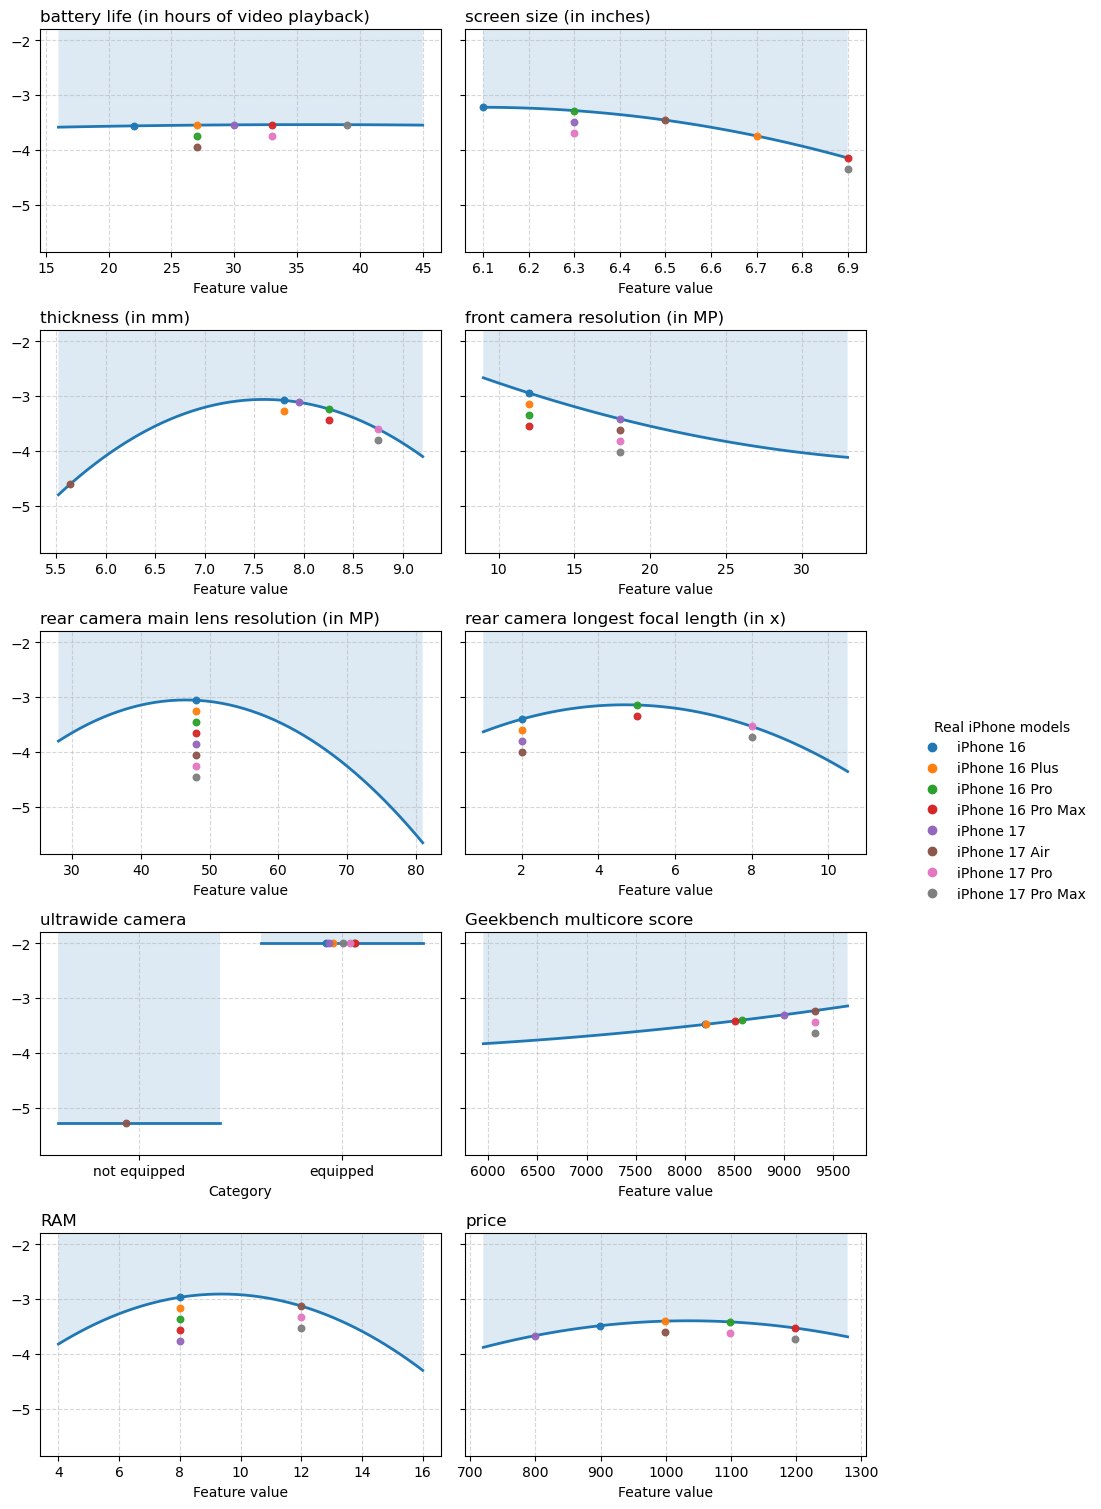

In [8]:
plot_pdp1d_grid(
    model,
    profiles_val,                               # UNprocessed data
    features=features,
    preprocessor=preprocess_test,          # function is OK!
    feature_types={"ultrawide camera": "categorical"},
    categories_map={"ultrawide camera": ["not equipped", "equipped"]},
    X_test = real_profiles,
)

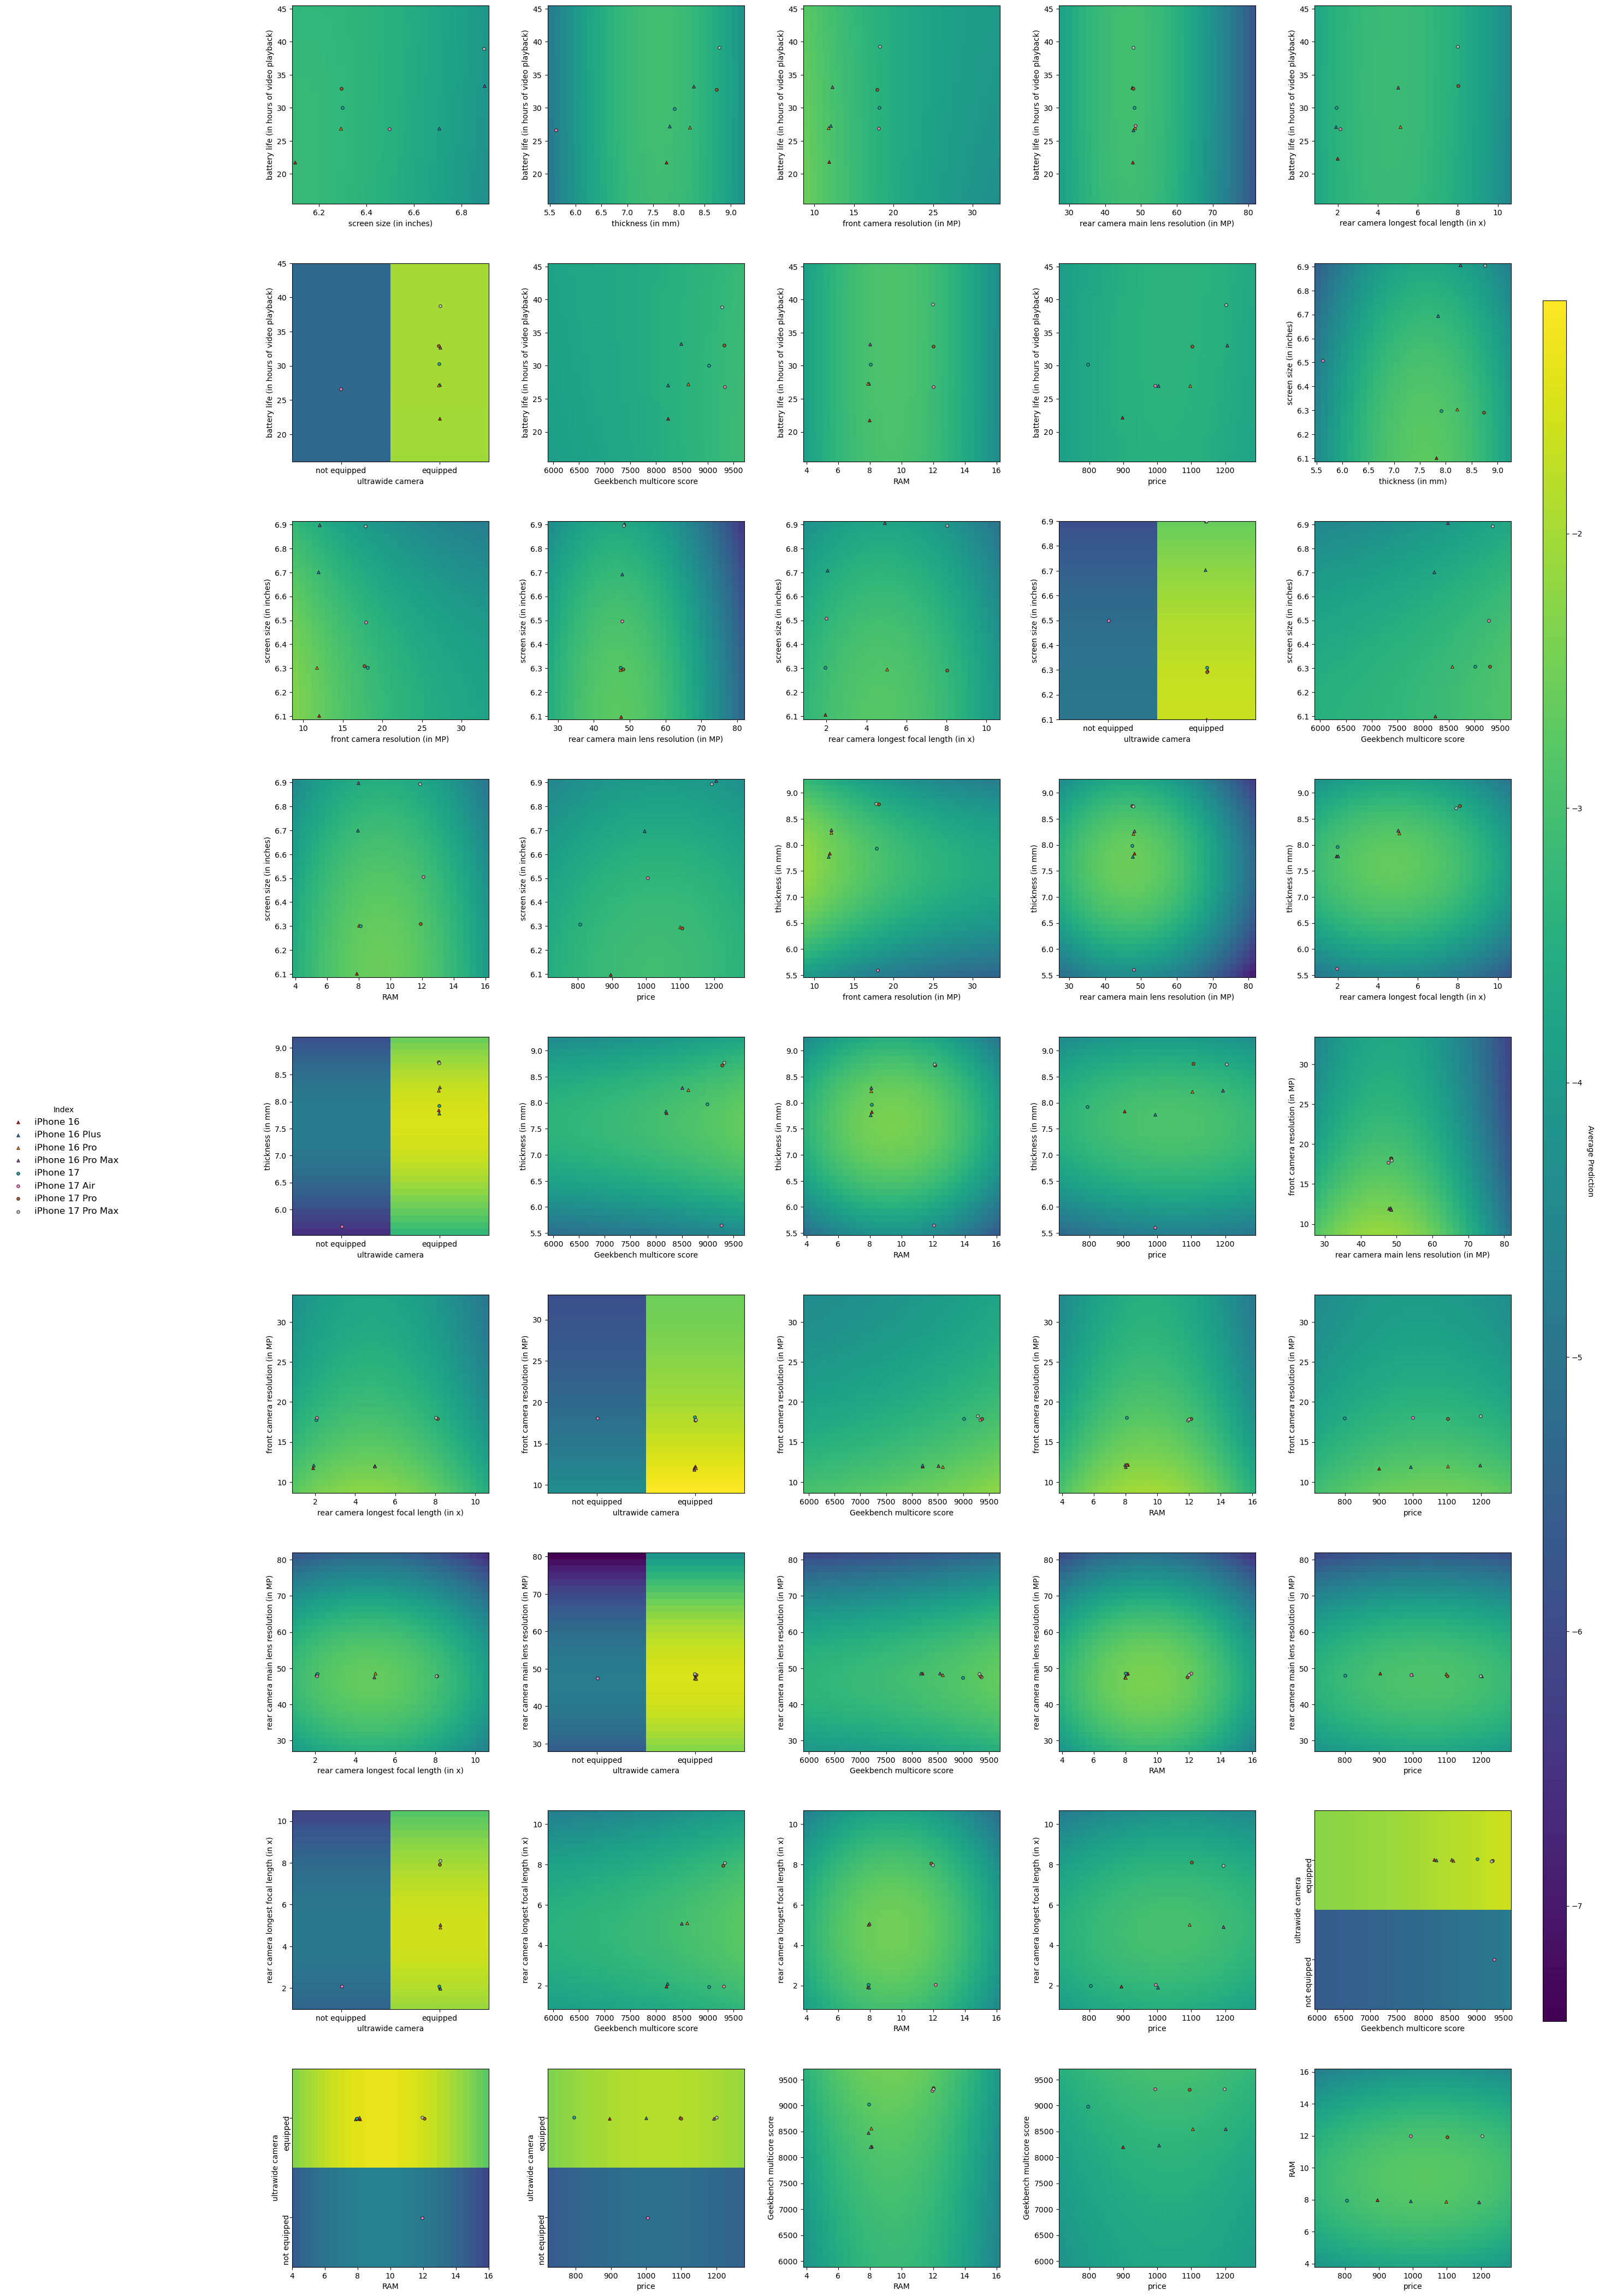

In [10]:
plot_pdp2d_grid(
    model, profiles_val, features,           # features: list of 10 names or indices
    preprocessor=preprocess_test,
    feature_types={"ultrawide camera": "categorical"},
    categories_map={"ultrawide camera": ["not equipped", "equipped"]},
    X_test=real_profiles,
    test_legend=True,
    test_annotate=False,
)

# MLP plots

In [12]:
## score all profiles
torch.manual_seed(2025)
model = MLPScorer(d_in=d, hidden=(256, 128), dropout=0.1)
model = train_pairwise(model, dl_tr, dl_va, lr=1e-3, weight_decay=1e-5, epochs=20)

[Epoch 01] train_loss=0.4667  val_loss=0.4095
[Epoch 02] train_loss=0.4036  val_loss=0.4027
[Epoch 03] train_loss=0.3936  val_loss=0.3982
[Epoch 04] train_loss=0.3827  val_loss=0.3912
[Epoch 05] train_loss=0.3818  val_loss=0.3979
[Epoch 06] train_loss=0.3726  val_loss=0.3891
[Epoch 07] train_loss=0.3697  val_loss=0.3908
[Epoch 08] train_loss=0.3664  val_loss=0.3993


In [13]:
plot_pdp1d_singlefeature(
    model,
    profiles_val,
    feature = "thickness (in mm)",
    preprocessor=preprocess_test,          # function is OK!
    feature_types={"ultrawide camera": "categorical"},
    categories_map={"ultrawide camera": ["not equipped", "equipped"]},
    X_test = real_profiles,
    marker_size = 60,
)
plot_pdp1d_singlefeature(
    model,
    profiles_val,
    feature = "screen size (in inches)",
    preprocessor=preprocess_test,          # function is OK!
    feature_types={"ultrawide camera": "categorical"},
    categories_map={"ultrawide camera": ["not equipped", "equipped"]},
    X_test = real_profiles,
    marker_size = 60,
)
plot_pdp1d_singlefeature(
    model,
    profiles_val,
    feature = "battery life (in hours of video playback)",
    preprocessor=preprocess_test,          # function is OK!
    feature_types={"ultrawide camera": "categorical"},
    categories_map={"ultrawide camera": ["not equipped", "equipped"]},
    X_test = real_profiles,
    marker_size = 60,
)
plot_pdp1d_singlefeature(
    model,
    profiles_val,
    feature = "rear camera main lens resolution (in MP)",
    preprocessor=preprocess_test,          # function is OK!
    feature_types={"ultrawide camera": "categorical"},
    categories_map={"ultrawide camera": ["not equipped", "equipped"]},
    X_test = real_profiles,
    marker_size = 60,
)

/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/pdp_plot.py:614: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0, right_space, 1])


Saved to: ../plot/MLPScorer_pdp_thickness (in mm).png


/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/pdp_plot.py:614: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0, right_space, 1])


Saved to: ../plot/MLPScorer_pdp_screen size (in inches).png


/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/pdp_plot.py:614: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0, right_space, 1])


Saved to: ../plot/MLPScorer_pdp_battery life (in hours of video playback).png


/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/pdp_plot.py:614: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0, right_space, 1])


Saved to: ../plot/MLPScorer_pdp_rear camera main lens resolution (in MP).png


/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/pdp_plot.py:401: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0, 1, 0.95])


Saved to: ../plot/MLPScorer_pdp1d_grid.png


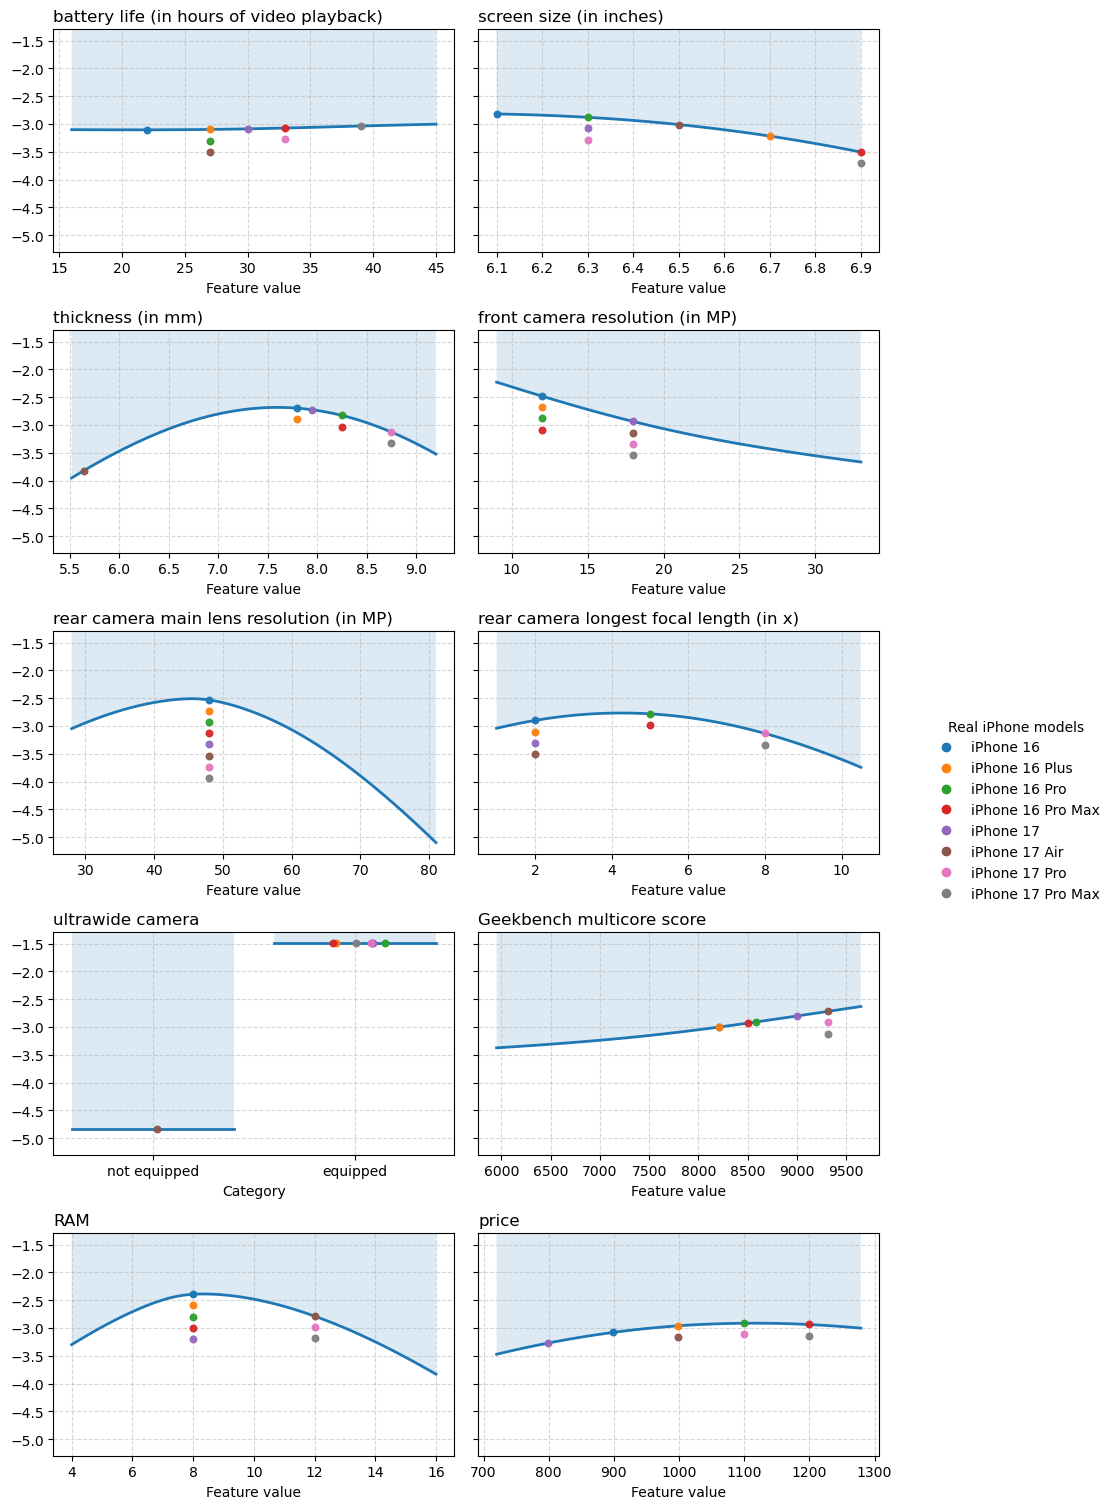

In [10]:
plot_pdp1d_grid(
    model,
    profiles_val,                               # UNprocessed data
    features=features,
    preprocessor=preprocess_test,          # function is OK!
    feature_types={"ultrawide camera": "categorical"},
    categories_map={"ultrawide camera": ["not equipped", "equipped"]},
    X_test = real_profiles,
)

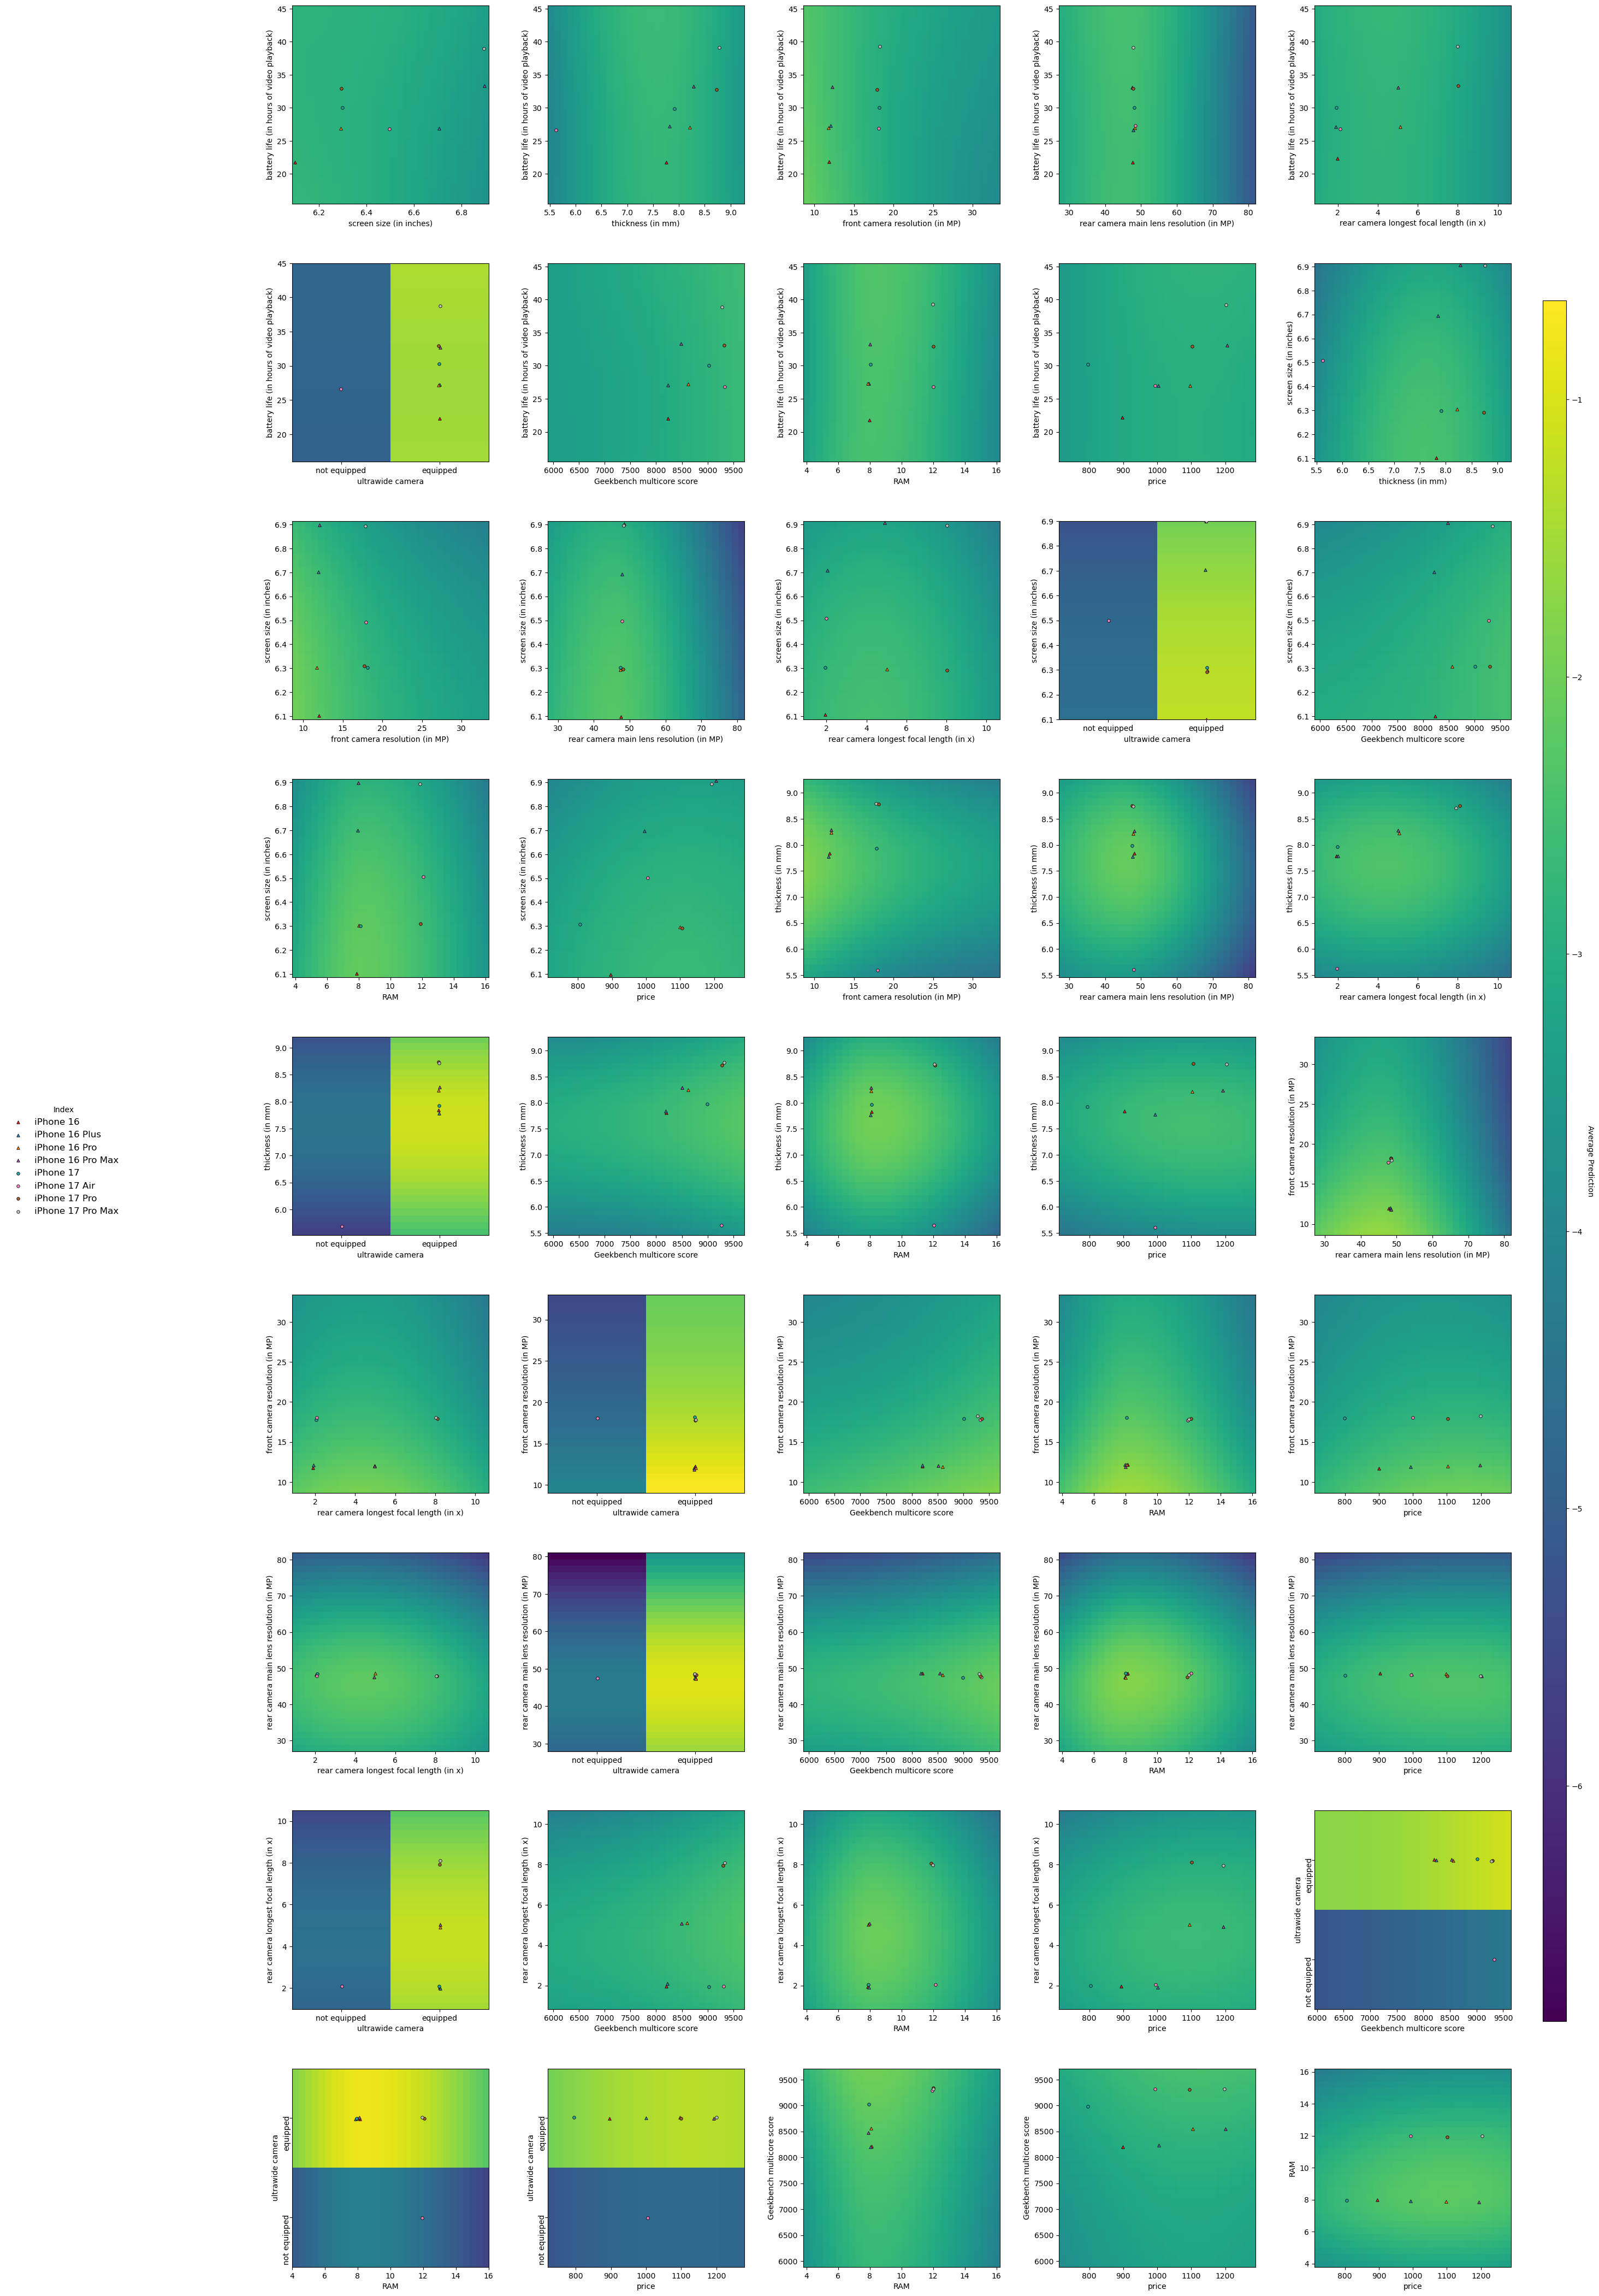

In [9]:
plot_pdp2d_grid(
    model, profiles_val, features,           # features: list of 10 names or indices
    preprocessor=preprocess_test,
    feature_types={"ultrawide camera": "categorical"},
    categories_map={"ultrawide camera": ["not equipped", "equipped"]},
    X_test=real_profiles,
    test_legend=True,
    test_annotate=False,
)

# MLP_Attention

In [7]:
# ==== MLP Attention ====
model = MLPAttentionScore(d_in=d, hidden=(256, 128), dropout=0.1, n_heads=2)
model = train_pairwise(model, dl_tr, dl_va, lr=1e-3, weight_decay=1e-5, epochs=20)

[Epoch 01] train_loss=0.4461  val_loss=0.4128
[Epoch 02] train_loss=0.3738  val_loss=0.3861
[Epoch 03] train_loss=0.3646  val_loss=0.3716
[Epoch 04] train_loss=0.3557  val_loss=0.3843
[Epoch 05] train_loss=0.3548  val_loss=0.3833


In [9]:
plot_pdp1d_singlefeature(
    model,
    profiles_val,
    feature = "ultrawide camera",
    preprocessor=preprocess_test,          # function is OK!
    feature_types={"ultrawide camera": "categorical"},
    categories_map={"ultrawide camera": ["not equipped", "equipped"]},
    X_test = real_profiles,
    marker_size = 60,
)

/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/pdp_plot.py:614: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0, right_space, 1])


Saved to: ../plot/MLPAttentionScore_pdp_ultrawide camera.png


In [8]:
plot_pdp1d_singlefeature(
    model,
    profiles_val,
    feature = "thickness (in mm)",
    preprocessor=preprocess_test,          # function is OK!
    feature_types={"ultrawide camera": "categorical"},
    categories_map={"ultrawide camera": ["not equipped", "equipped"]},
    X_test = real_profiles,
    marker_size = 60,
)

Saved to: ../plot/MLPAttentionScore_pdp_thickness (in mm).png


/Users/xiaobaodawang/Research/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/pdp_plot.py:624: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0, right_space, 1])


In [ ]:

plot_pdp1d_singlefeature(
    model,
    profiles_val,
    feature = "screen size (in inches)",
    preprocessor=preprocess_test,          # function is OK!
    feature_types={"ultrawide camera": "categorical"},
    categories_map={"ultrawide camera": ["not equipped", "equipped"]},
    X_test = real_profiles,
    marker_size = 60,
)
plot_pdp1d_singlefeature(
    model,
    profiles_val,
    feature = "battery life (in hours of video playback)",
    preprocessor=preprocess_test,          # function is OK!
    feature_types={"ultrawide camera": "categorical"},
    categories_map={"ultrawide camera": ["not equipped", "equipped"]},
    X_test = real_profiles,
    marker_size = 60,
)
plot_pdp1d_singlefeature(
    model,
    profiles_val,
    feature = "rear camera main lens resolution (in MP)",
    preprocessor=preprocess_test,          # function is OK!
    feature_types={"ultrawide camera": "categorical"},
    categories_map={"ultrawide camera": ["not equipped", "equipped"]},
    X_test = real_profiles,
    marker_size = 60,
)

/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/pdp_plot.py:614: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0, right_space, 1])


Saved to: ../plot/MLPAttentionScore_pdp_thickness (in mm).png


/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/pdp_plot.py:614: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0, right_space, 1])


Saved to: ../plot/MLPAttentionScore_pdp_screen size (in inches).png


/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/pdp_plot.py:614: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0, right_space, 1])


Saved to: ../plot/MLPAttentionScore_pdp_battery life (in hours of video playback).png


/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/pdp_plot.py:614: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0, right_space, 1])


Saved to: ../plot/MLPAttentionScore_pdp_rear camera main lens resolution (in MP).png


/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/pdp_plot.py:401: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0, 1, 0.95])


Saved to: ../plot/MLPAttentionScore_pdp1d_grid.png


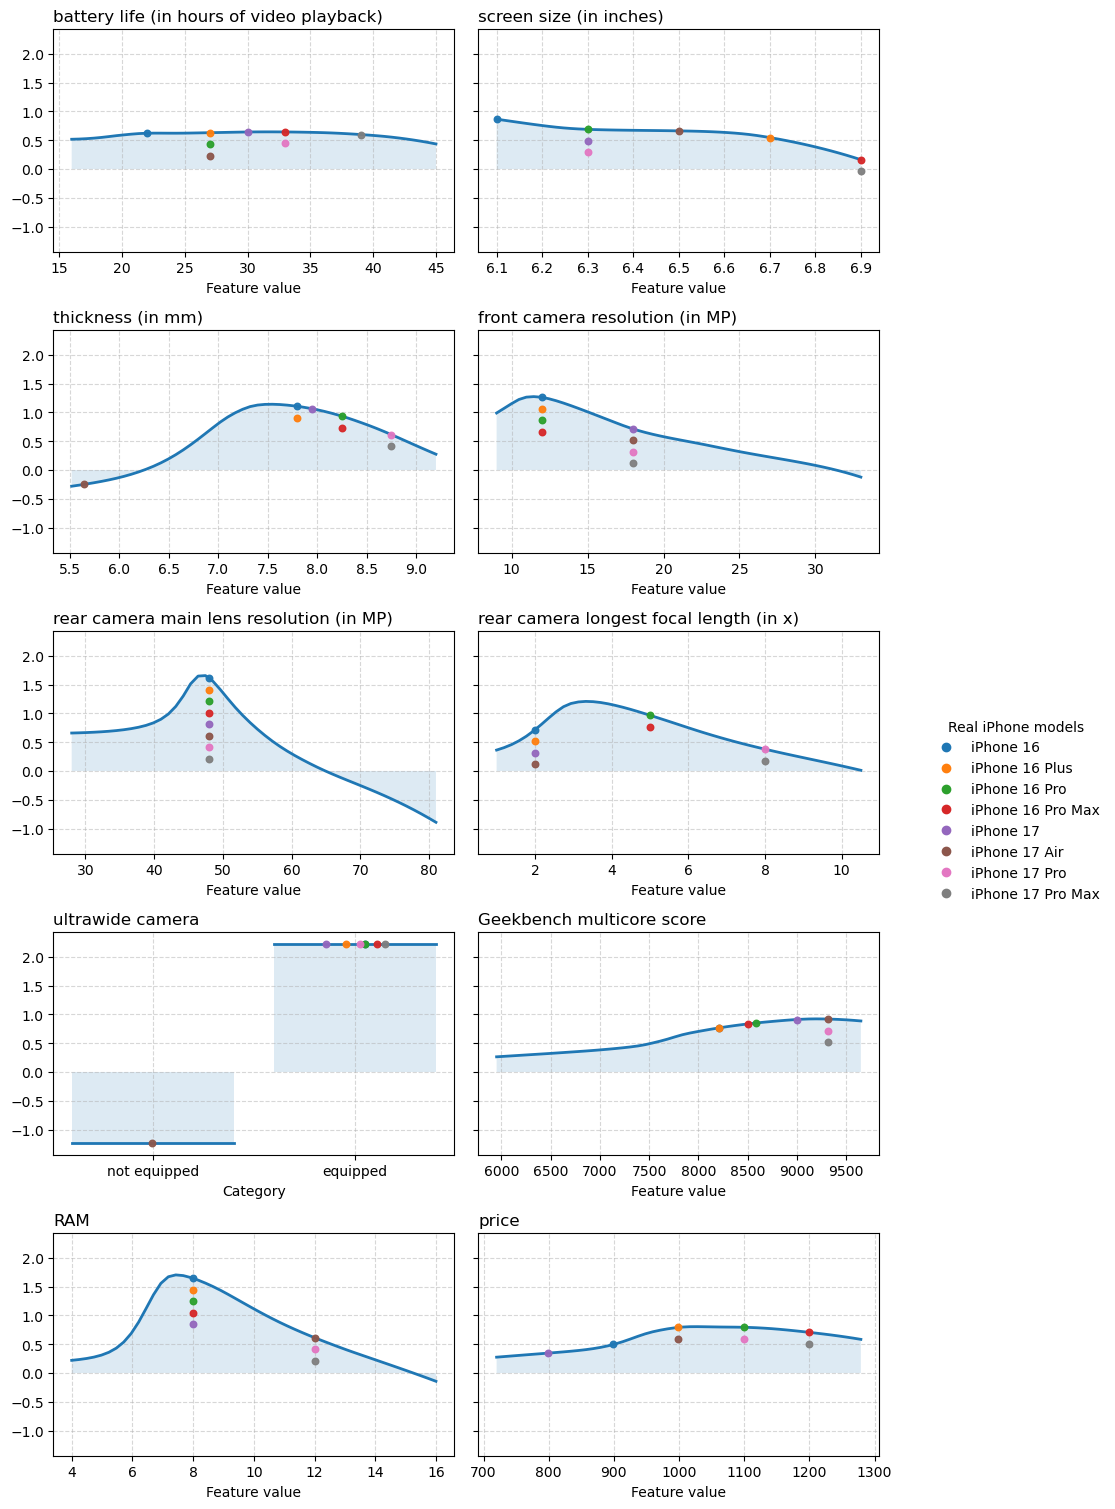

In [12]:
plot_pdp1d_grid(
    model,
    profiles_val,                          # UNprocessed data
    features=features,
    preprocessor=preprocess_test,          # function is OK!
    feature_types={"ultrawide camera": "categorical"},
    categories_map={"ultrawide camera": ["not equipped", "equipped"]},
    X_test=real_profiles,
)

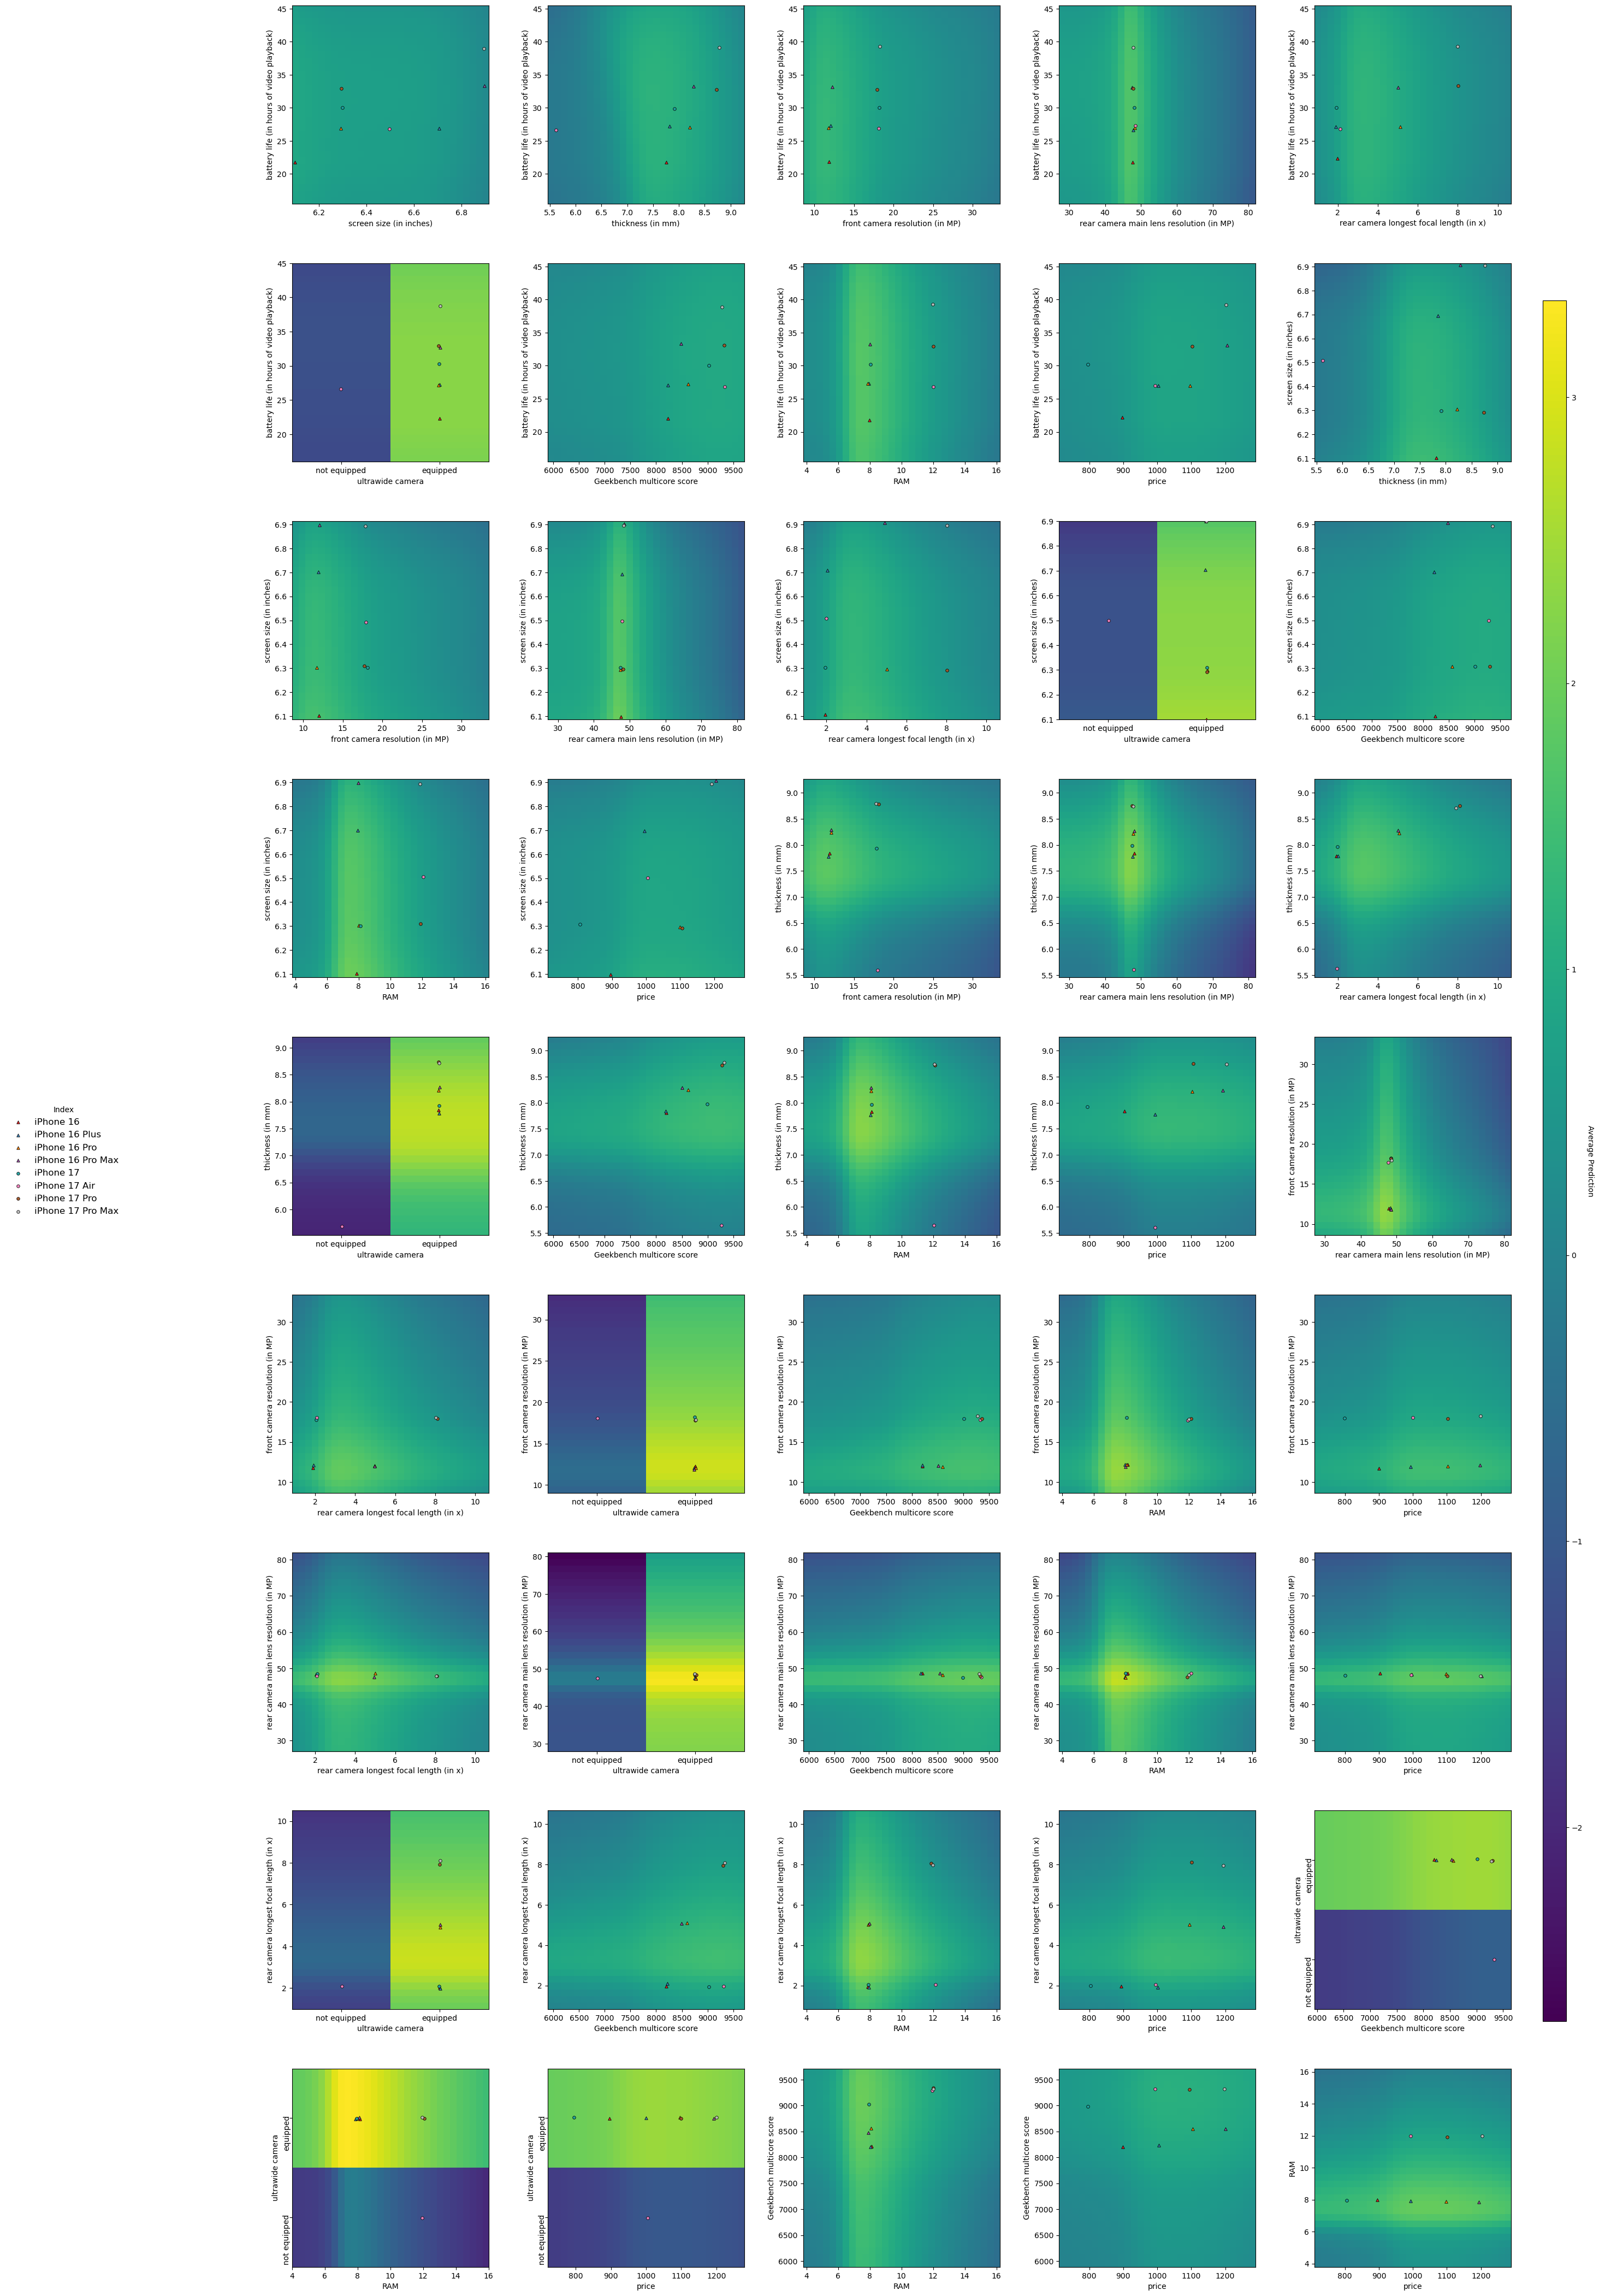

In [12]:
plot_pdp2d_grid(
    model, profiles_val, features,           # features: list of 10 names or indices
    preprocessor=preprocess_test,
    feature_types={"ultrawide camera": "categorical"},
    categories_map={"ultrawide camera": ["not equipped", "equipped"]},
    X_test=real_profiles,
    test_legend=True,
    test_annotate=False,
)

# Logistic Regression

In [17]:
torch.manual_seed(2025)
model = LogisticRegression(d_in=d)
model = train_pairwise(model, dl_tr, dl_va, lr=1e-3, weight_decay=1e-5, epochs=20)

[Epoch 01] train_loss=0.6710  val_loss=0.6235
[Epoch 02] train_loss=0.6055  val_loss=0.5807
[Epoch 03] train_loss=0.5669  val_loss=0.5554
[Epoch 04] train_loss=0.5423  val_loss=0.5383
[Epoch 05] train_loss=0.5248  val_loss=0.5255
[Epoch 06] train_loss=0.5112  val_loss=0.5144
[Epoch 07] train_loss=0.5001  val_loss=0.5054
[Epoch 08] train_loss=0.4908  val_loss=0.4973
[Epoch 09] train_loss=0.4826  val_loss=0.4904
[Epoch 10] train_loss=0.4757  val_loss=0.4843
[Epoch 11] train_loss=0.4697  val_loss=0.4791
[Epoch 12] train_loss=0.4645  val_loss=0.4743
[Epoch 13] train_loss=0.4600  val_loss=0.4706
[Epoch 14] train_loss=0.4561  val_loss=0.4673
[Epoch 15] train_loss=0.4527  val_loss=0.4644
[Epoch 16] train_loss=0.4497  val_loss=0.4618
[Epoch 17] train_loss=0.4471  val_loss=0.4597
[Epoch 18] train_loss=0.4450  val_loss=0.4578
[Epoch 19] train_loss=0.4431  val_loss=0.4564
[Epoch 20] train_loss=0.4415  val_loss=0.4551


In [18]:
plot_pdp1d_singlefeature(
    model,
    profiles_val,
    feature = "thickness (in mm)",
    preprocessor=preprocess_test,          # function is OK!
    feature_types={"ultrawide camera": "categorical"},
    categories_map={"ultrawide camera": ["not equipped", "equipped"]},
    X_test = real_profiles,
    marker_size = 60,
)
plot_pdp1d_singlefeature(
    model,
    profiles_val,
    feature = "screen size (in inches)",
    preprocessor=preprocess_test,          # function is OK!
    feature_types={"ultrawide camera": "categorical"},
    categories_map={"ultrawide camera": ["not equipped", "equipped"]},
    X_test = real_profiles,
    marker_size = 60,
)
plot_pdp1d_singlefeature(
    model,
    profiles_val,
    feature = "battery life (in hours of video playback)",
    preprocessor=preprocess_test,          # function is OK!
    feature_types={"ultrawide camera": "categorical"},
    categories_map={"ultrawide camera": ["not equipped", "equipped"]},
    X_test = real_profiles,
    marker_size = 60,
)
plot_pdp1d_singlefeature(
    model,
    profiles_val,
    feature = "rear camera main lens resolution (in MP)",
    preprocessor=preprocess_test,          # function is OK!
    feature_types={"ultrawide camera": "categorical"},
    categories_map={"ultrawide camera": ["not equipped", "equipped"]},
    X_test = real_profiles,
    marker_size = 60,
)

/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/pdp_plot.py:614: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0, right_space, 1])


Saved to: ../plot/LogisticRegression_pdp_thickness (in mm).png


/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/pdp_plot.py:614: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0, right_space, 1])


Saved to: ../plot/LogisticRegression_pdp_screen size (in inches).png


/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/pdp_plot.py:614: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0, right_space, 1])


Saved to: ../plot/LogisticRegression_pdp_battery life (in hours of video playback).png


/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/pdp_plot.py:614: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0, right_space, 1])


Saved to: ../plot/LogisticRegression_pdp_rear camera main lens resolution (in MP).png


/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/pdp_plot.py:403: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0, 1, 0.95])


Saved to: ../plot/LogisticRegression_pdp1d_grid.png


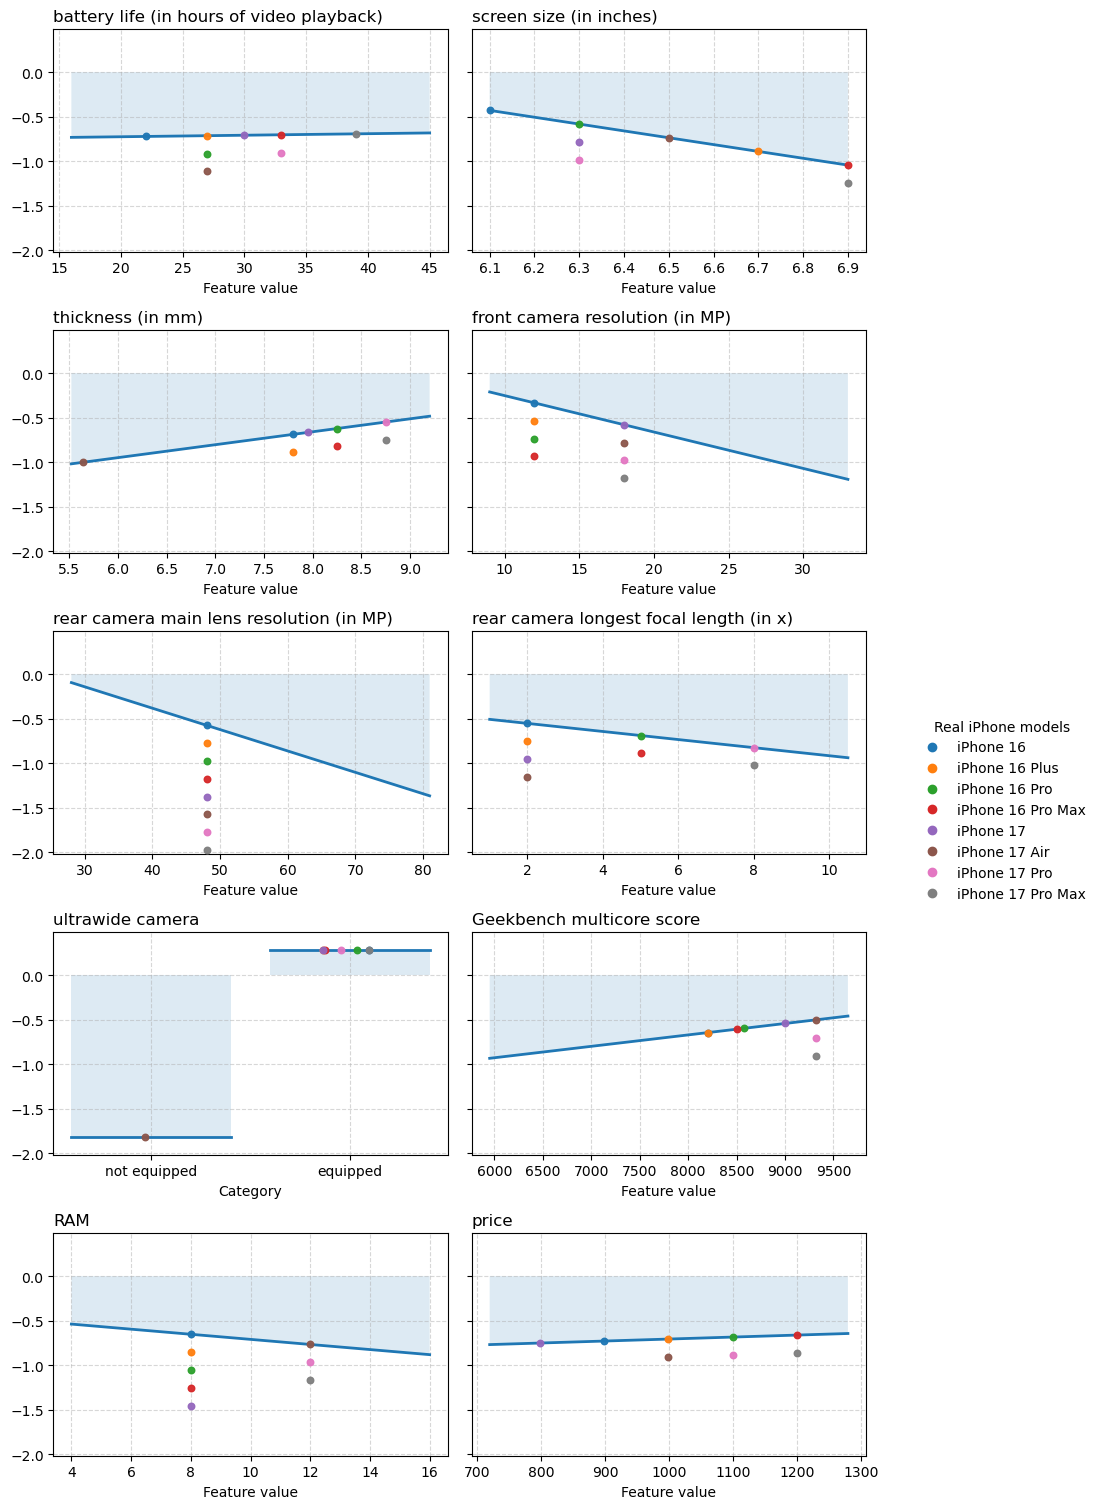

In [19]:
plot_pdp1d_grid(
    model,
    profiles_val,                          # UNprocessed data
    features=features,
    preprocessor=preprocess_test,          # function is OK!
    feature_types={"ultrawide camera": "categorical"},
    categories_map={"ultrawide camera": ["not equipped", "equipped"]},
    X_test=real_profiles,
)

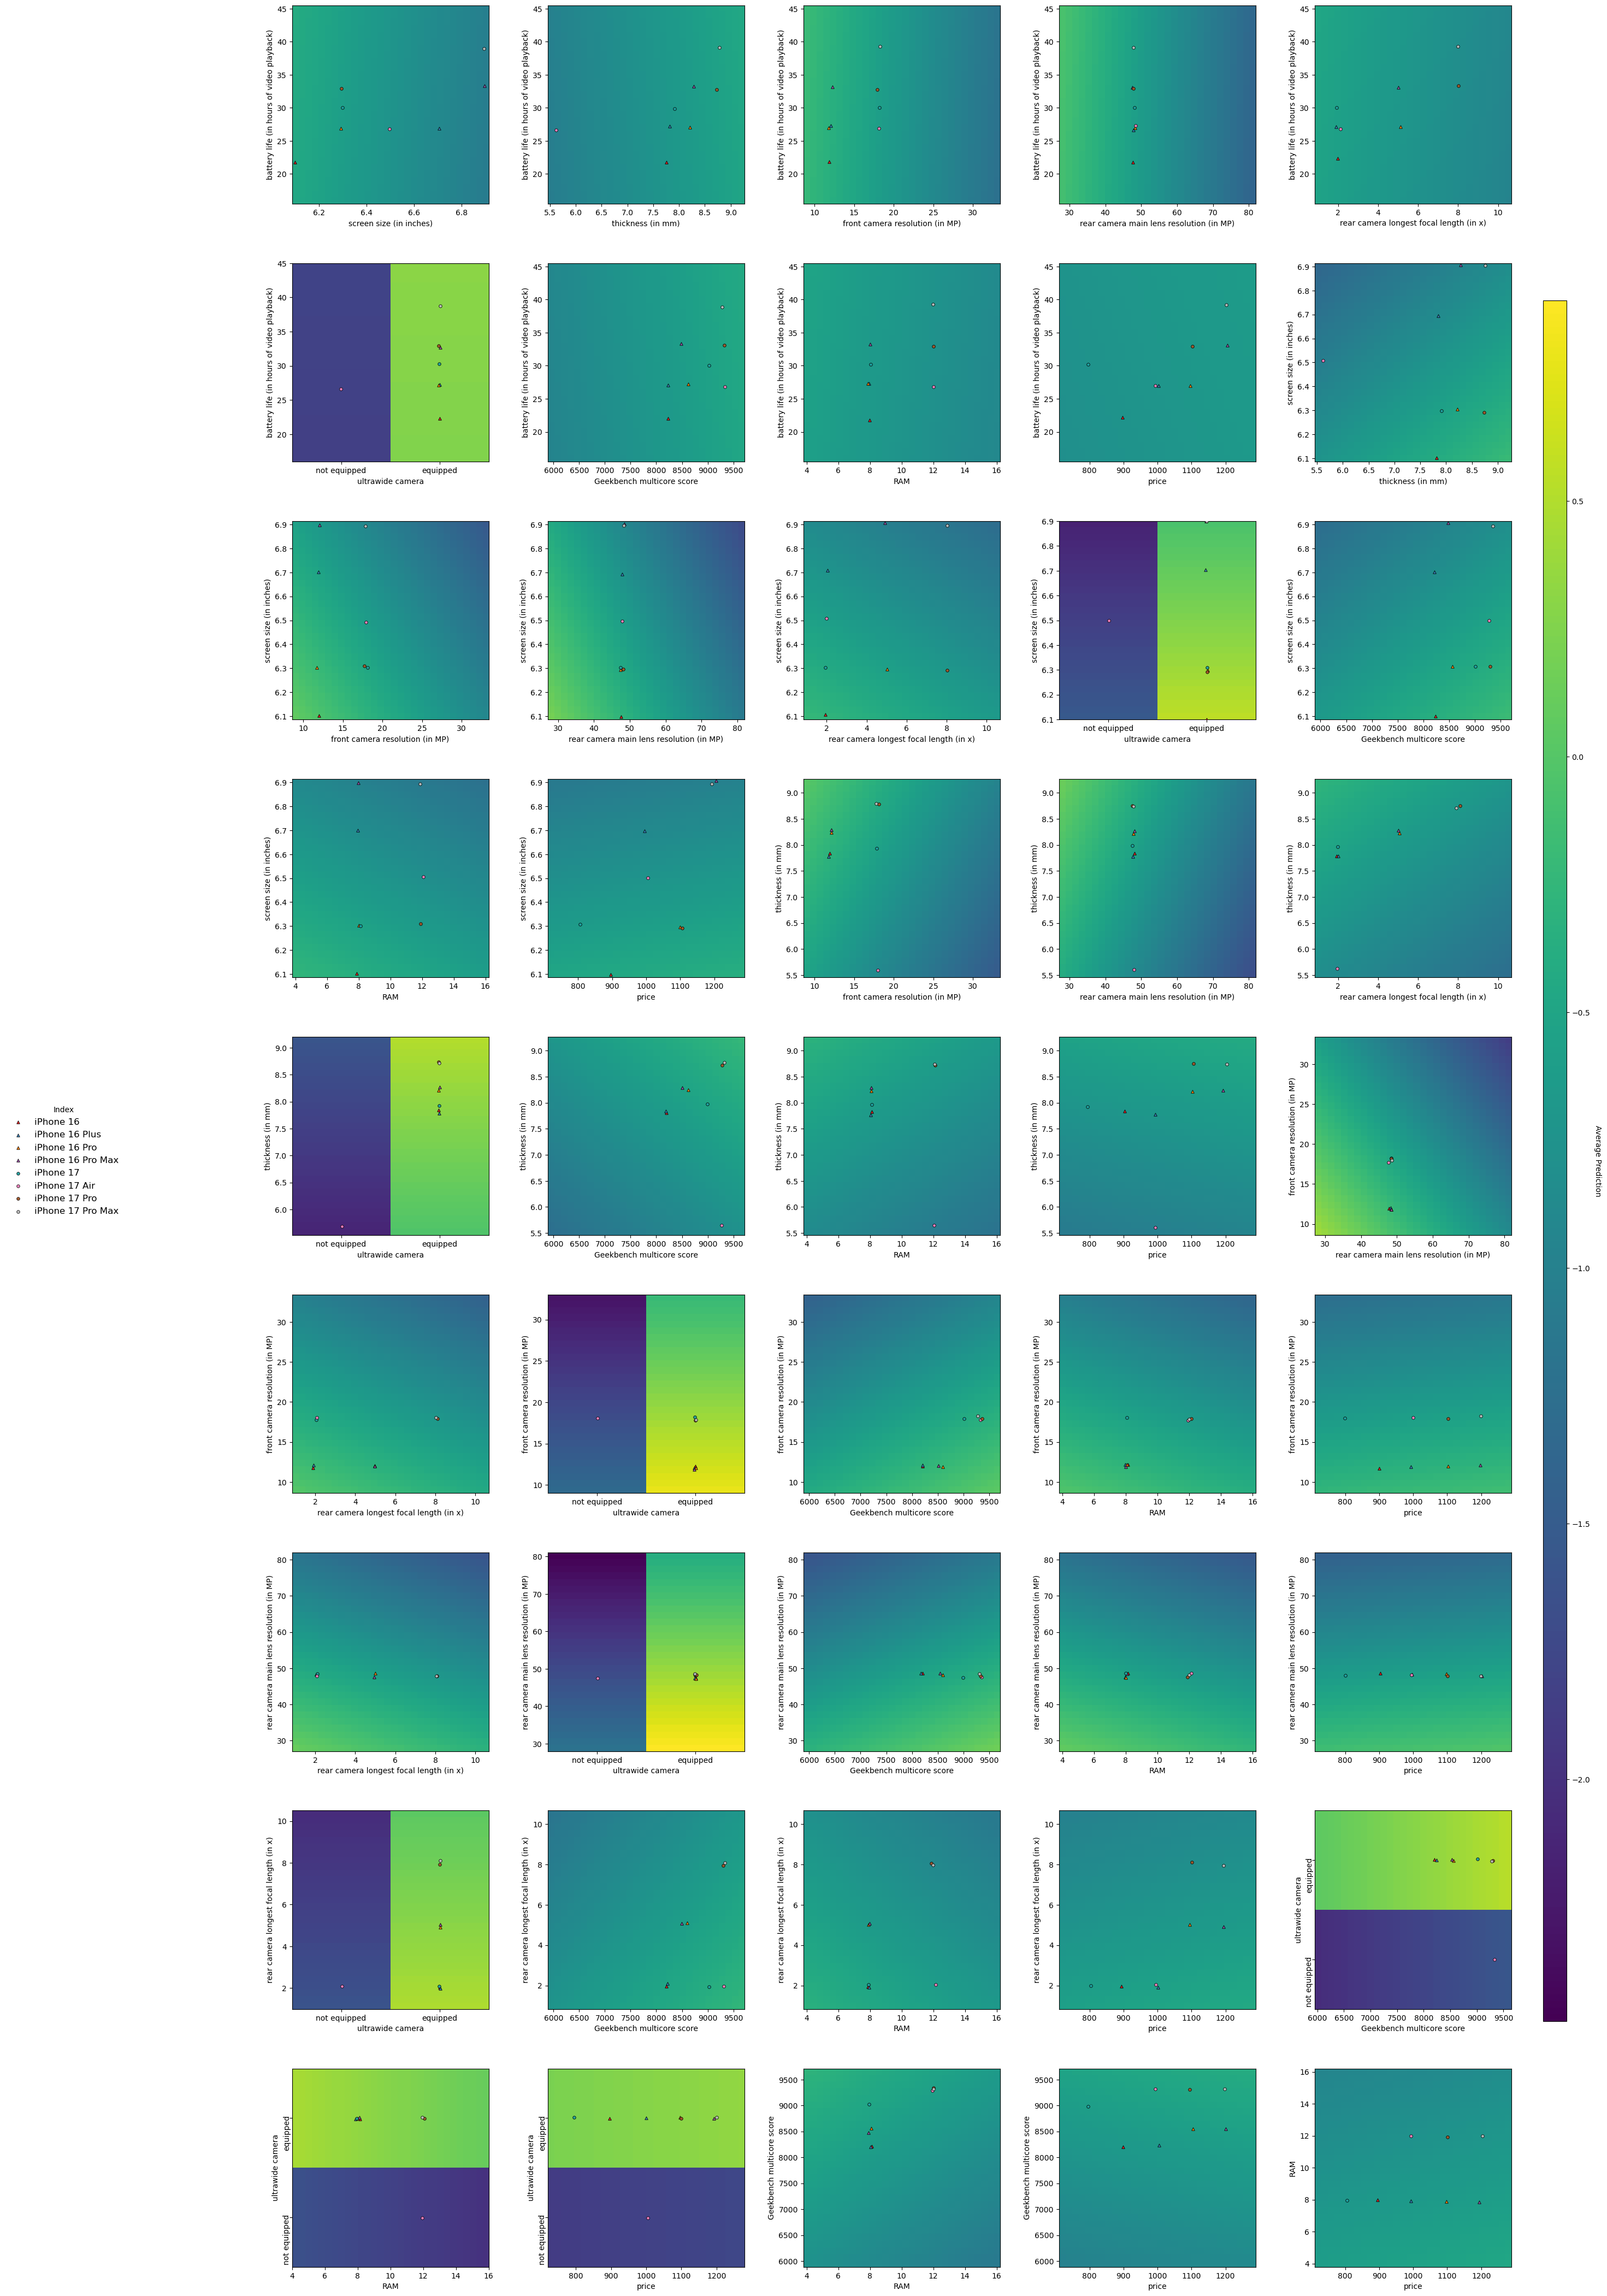

In [15]:
plot_pdp2d_grid(
    model, profiles_val, features,           # features: list of 10 names or indices
    preprocessor=preprocess_test,
    feature_types={"ultrawide camera": "categorical"},
    categories_map={"ultrawide camera": ["not equipped", "equipped"]},
    X_test=real_profiles,
    test_legend=True,
    test_annotate=False,
)